# __TWITTER AIRLINE SENTIMENT ANALYSIS__

Airlines receive constant customer feedback on Twitter — both positive and negative.                                   
This project performs sentiment analysis on tweets about six major U.S. airlines to classify sentiments as positive, neutral, or negative.                                                   
The Airlines are - United, US Airways, American, Southwest, Delta, Virgin America                     

__Source:__ https://www.kaggle.com/crowdflower/twitter-airline-sentimenthttps://www.kaggle.com/crowdflower/twitter-airline-sentiment

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import re
import os
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

nltk.download('stopwords')
from nltk.corpus import stopwords

sns.set(style="whitegrid")

C:\Users\Arunita\anaconda31\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arunita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [2]:

# Data Source - https://www.kaggle.com/crowdflower/twitter-airline-sentiment

DATA_PATH = 'C:/Users/Arunita/__Next Steps - 2025__/Data Science Starter Kit/data/Tweets.csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError('Place the required file in the folder.')

tweets = pd.read_csv(DATA_PATH)
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Dataset overview

In [3]:
print("Dataset Shape:", tweets.shape)
print(tweets.info())
print(tweets['airline_sentiment'].value_counts())
print("Airlines are:", tweets["airline"].value_counts())

Dataset Shape: (14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 146

# Data Cleaning and Preprocessing

In [4]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\\S+", "", text)        # Remove URLs
    text = re.sub(r"@\\w+", "", text)           # remove mentions
    text = re.sub(r"#", "", text)               # remove hashtags symbol
    text = re.sub(r"[^A-Za-z0-9\\s]", "", text) # remove special chars
    text = text.lower()
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

tweets["clean_text"] = tweets["text"].apply(clean_text)

# Feature Extraction

In [5]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(tweets["clean_text"])
y = tweets["airline_sentiment"]

# Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

# Model Training before Imbalance Handling

## Logistic Regression

In [7]:
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print("Logistic Regression Results:")

print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

    negative       0.63      1.00      0.77      1835
     neutral       1.00      0.00      0.01       620
    positive       0.91      0.04      0.08       473

    accuracy                           0.63      2928
   macro avg       0.85      0.35      0.29      2928
weighted avg       0.75      0.63      0.50      2928



## Multinomial Naive Bayes

In [8]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)
print("Naive Bayes Results:")

print(classification_report(y_test, y_pred_nb))

Naive Bayes Results:
              precision    recall  f1-score   support

    negative       0.63      1.00      0.77      1835
     neutral       1.00      0.00      0.01       620
    positive       0.91      0.04      0.08       473

    accuracy                           0.63      2928
   macro avg       0.85      0.35      0.29      2928
weighted avg       0.75      0.63      0.50      2928



# Evaluation

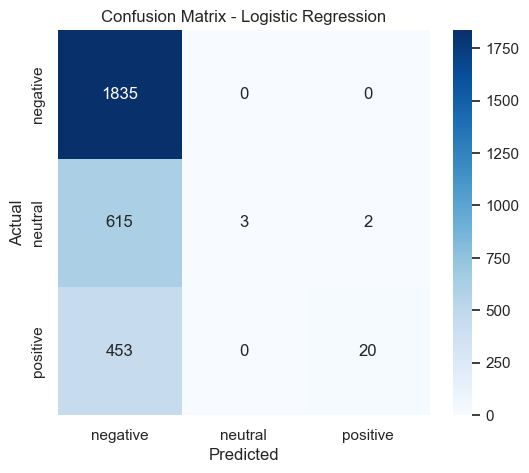

In [9]:
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf_lr.classes_, yticklabels=clf_lr.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Handle class balance with SMOTE

In [10]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_balanced).value_counts().to_dict())

Before SMOTE: {'negative': 7343, 'neutral': 2479, 'positive': 1890}
After SMOTE: {'neutral': 7343, 'negative': 7343, 'positive': 7343}


# Model Training with Balance classes

## - Logistic Regression (with balanced classes)

In [11]:
clf_lr_bl = LogisticRegression(max_iter=1000, solver="liblinear")
clf_lr_bl.fit(X_train_balanced, y_train_balanced)
y_pred_lr_bl = clf_lr_bl.predict(X_test)

## - Naive Bayes

In [12]:
clf_nb_bl = MultinomialNB()
clf_nb_bl.fit(X_train_balanced, y_train_balanced)
y_pred_nb_bl = clf_nb_bl.predict(X_test)

## - XGBoost

__Encode labels for XGBoost__

In [13]:
label_encoder = LabelEncoder()
y_train_bal = label_encoder.fit_transform(y_train_balanced)
y_test_enc   = label_encoder.transform(y_test)

__Train model__

In [14]:
clf_xgb_bl = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)
clf_xgb_bl.fit(X_train_balanced, y_train_bal)
y_pred_xgb_bl = clf_xgb_bl.predict(X_test)
y_pred_xgb_bl = label_encoder.inverse_transform(y_pred_xgb_bl) # Convert back to string (otherwise model evaluation will throw error)

C:\Users\Arunita\anaconda31\lib\site-packages\xgboost\training.py:183: UserWarning: [18:44:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


__Evaluate Model__

In [15]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"=== {name} ===")
    print(classification_report(y_true, y_pred))
    return [name, acc, macro_f1, weighted_f1]

results = []
results.append(evaluate_model("Logistic Regression", y_test, y_pred_lr_bl))
results.append(evaluate_model("Naive Bayes", y_test, y_pred_nb_bl))
results.append(evaluate_model("XGBoost", y_test, y_pred_xgb_bl))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro F1", "Weighted F1"])
print(results_df)

=== Logistic Regression ===
              precision    recall  f1-score   support

    negative       0.64      1.00      0.78      1835
     neutral       0.79      0.02      0.05       620
    positive       0.88      0.06      0.11       473

    accuracy                           0.64      2928
   macro avg       0.77      0.36      0.31      2928
weighted avg       0.71      0.64      0.52      2928

=== Naive Bayes ===
              precision    recall  f1-score   support

    negative       0.61      0.62      0.62      1835
     neutral       0.19      0.32      0.24       620
    positive       0.88      0.06      0.11       473

    accuracy                           0.47      2928
   macro avg       0.56      0.33      0.32      2928
weighted avg       0.56      0.47      0.46      2928

=== XGBoost ===
              precision    recall  f1-score   support

    negative       0.63      1.00      0.78      1835
     neutral       0.82      0.01      0.03       620
    positiv

## Confusion Matrix for balanced classes

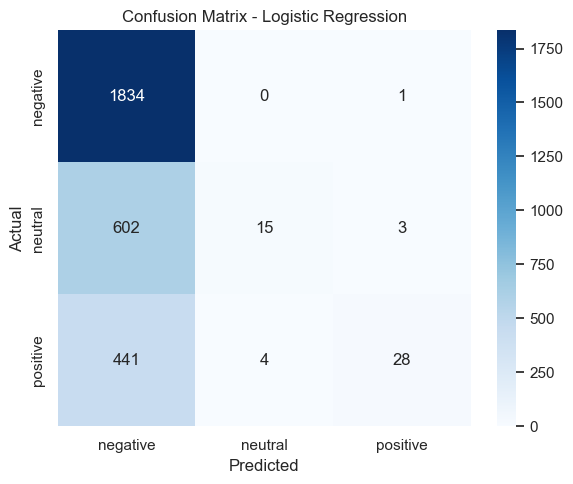

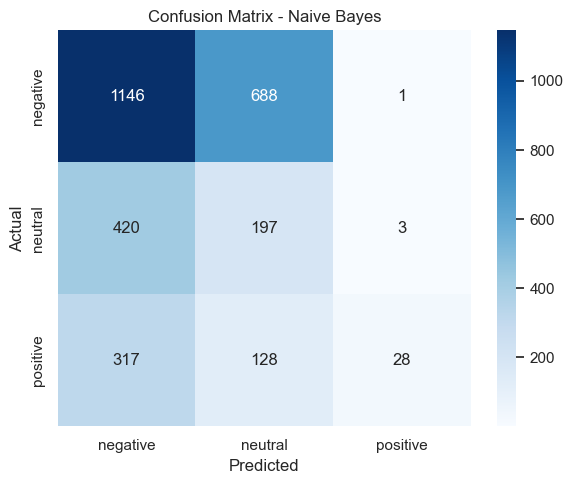

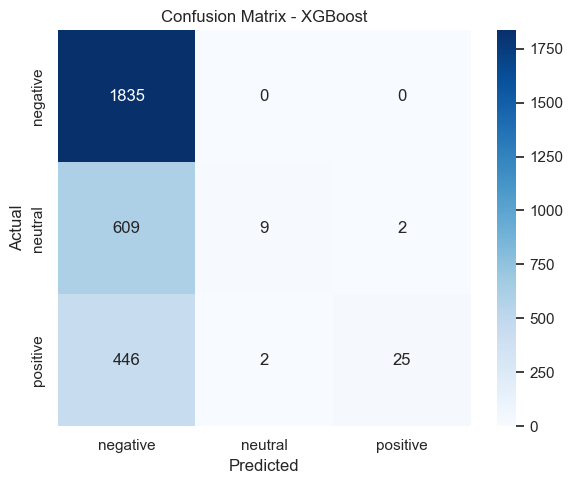

In [16]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clf_lr.classes_,
                yticklabels=clf_lr.classes_)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    #plt.savefig(f"visuals/confusion_matrix_{title.replace(' ', '_').lower()}.png", dpi=300)
    plt.show()

plot_confusion_matrix(y_test, y_pred_lr_bl, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_nb_bl, "Naive Bayes")
plot_confusion_matrix(y_test, y_pred_xgb_bl, "XGBoost")

# Visualization

## - Sentiment distribution bar chart

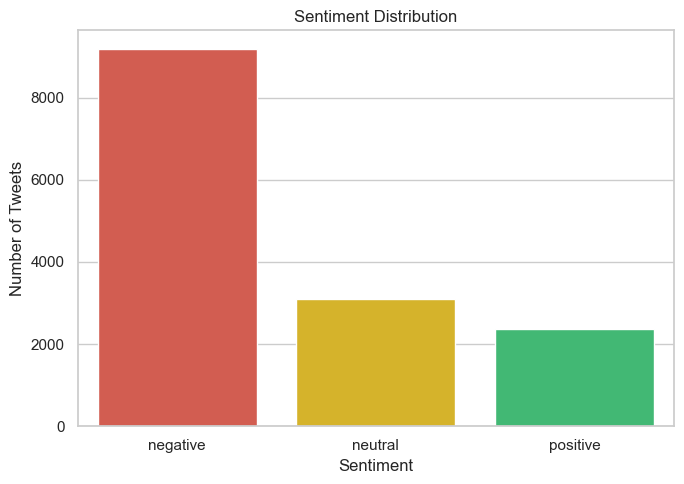

In [17]:
# Plot Sentiment Distribution

plt.figure(figsize=(7,5))
sns.countplot(data=tweets, x="airline_sentiment",
              order=tweets["airline_sentiment"].value_counts().index,
              palette=["#E74C3C", "#F1C40F", "#2ECC71"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.tight_layout()
#plt.savefig("visuals/sentiment_distribution.png", dpi=300)
plt.show()

## - WordCloud for positive, negative and neutral tweets

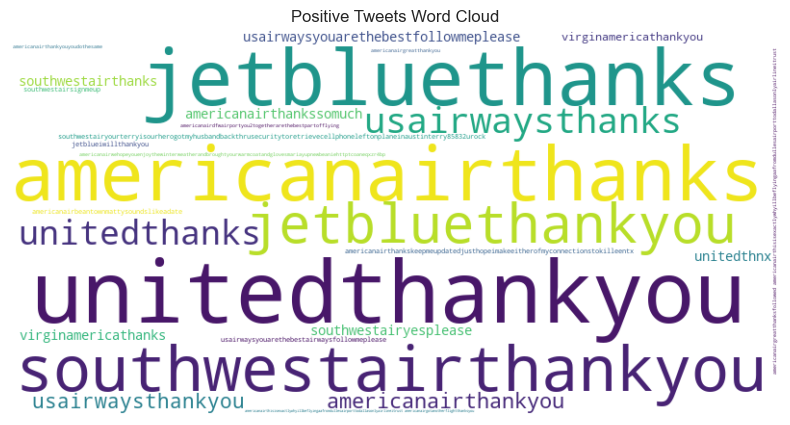

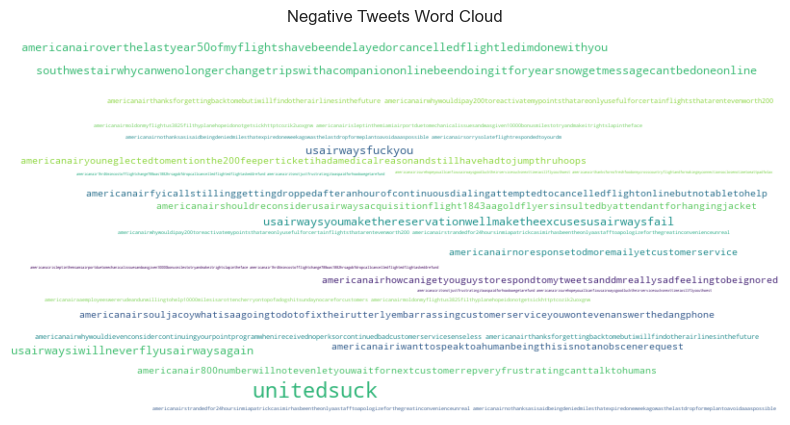

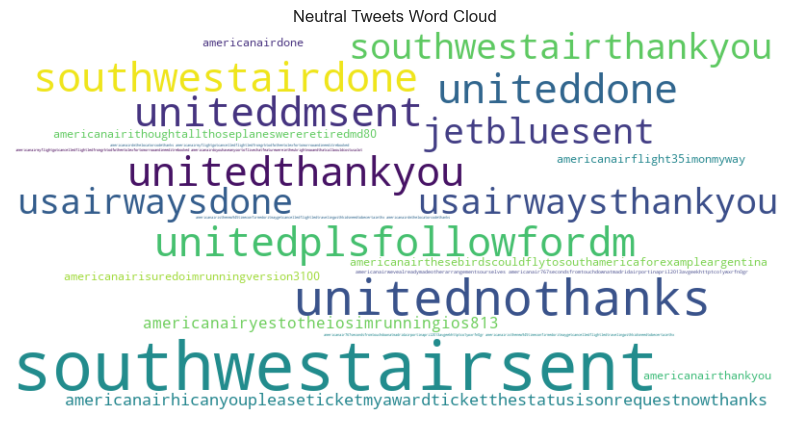

In [18]:
positive_text = " ".join(tweets[tweets["airline_sentiment"]=="positive"]["clean_text"].astype(str))
negative_text = " ".join(tweets[tweets["airline_sentiment"]=="negative"]["clean_text"].astype(str))
neutral_text  = " ".join(tweets[tweets["airline_sentiment"]=="neutral"]["clean_text"].astype(str))

# Positive tweets word cloud
if positive_text.strip():
    wc_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc_pos, interpolation="bilinear")
    plt.axis("off")
    plt.title("Positive Tweets Word Cloud")
    plt.show()

# Negative tweets word cloud
if negative_text.strip():
    wc_neg = WordCloud(width=800, height=400, background_color="white").generate(negative_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc_neg, interpolation="bilinear")
    plt.axis("off")
    plt.title("Negative Tweets Word Cloud")
    plt.show()

# Neutral tweets word cloud
if neutral_text.strip():
    wc_neu = WordCloud(width=800, height=400, background_color="white").generate(neutral_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc_neu, interpolation="bilinear")
    plt.axis("off")
    plt.title("Neutral Tweets Word Cloud")
    plt.show()

# Insights

1. Almost all the airlines have received positive feedback from their customers. Though almost everyone has not gone past writing "thank you". People are very lazy while writing reviews (including me).
2. Embarrasingly united is the one who have received the most negative comment. Though us airways, southwest and american air share the space, but not significantly.
3. The neutral comments really don't make any sense. It looks like people have written the reviews just for the sake of it.